In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import math
from time import strftime, localtime

% matplotlib inline

CUDA = False

In [2]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super(CausalConv1d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=0,
            dilation=dilation, groups=groups, bias=bias)

        self.left_padding = dilation * (kernel_size - 1)
        
    def forward(self, input):
        temp = torch.unsqueeze(input, 0)
        x = F.pad(temp, (self.left_padding, 0, 0, 0))
        x = torch.squeeze(x, 0)
        
        return super(CausalConv1d, self).forward(x)

In [3]:
class OneHot(nn.Module):
    def __init__(self, quant):
        super(OneHot, self).__init__()
        self.one = torch.sparse.torch.eye(quant)
        
    def forward(self, input):
        return Variable(self.one.index_select(0, input.data)).unsqueeze(0).transpose(1,2)

In [4]:
class WaveNet(nn.Module):
    def __init__(self, quant = 256, res_size = 512, skip_size = 256, dilation_layers = 10, stacks = 3):
        super(WaveNet, self).__init__()
        self.dilation_layers = dilation_layers
        self.dilations = dilations = [(2**dilation) for dilation in range(dilation_layers)] * stacks
        self.one_hot = OneHot(quant)
        
        self.causal_conv = CausalConv1d(1, res_size, 3)
        
        self.dial_conv = nn.ModuleList([CausalConv1d(res_size, res_size, 3, dilation = d) for d in dilations])
 
        self.dial_skip_conv = nn.ModuleList([CausalConv1d(skip_size, skip_size, 1) for _ in dilations])
        self.dial_res_conv = nn.ModuleList([CausalConv1d(skip_size, res_size, 1) for _ in dilations])
        
        self.end_conv1 = nn.Conv1d(in_channels = skip_size, out_channels = skip_size, kernel_size = 1)
        self.end_conv2 = nn.Conv1d(in_channels = skip_size, out_channels = quant, kernel_size = 1)

    def forward(self, input):
#         output = self.one_hot(input)
        output = input.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)
        output = self.causal_conv(output)
        
        skip_sum = []
        for d_conv, skip_conv, res_conv in zip(self.dial_conv, self.dial_skip_conv, self.dial_res_conv):
            res_output = output
            
            gate_output = self.gated_unit(res_output, d_conv)
            
            output = res_conv(gate_output)
            output = output + res_output[:,:,-output.size(2):]
            
            skip = skip_conv(gate_output)
            skip_sum.append(skip)
        
        output = sum([s[:,:,-output.size(2):] for s in skip_sum])
        
        output = self.postprocess(output)
        
        return output
    
    def gated_unit(self, input, dial_conv):
        output = dial_conv(input)
        
        output_sigmoid = output[0][256:].unsqueeze(0)
        output_tanh = output[0][:256].unsqueeze(0)

        output = F.sigmoid(output_sigmoid) * F.tanh(output_tanh)
        
        return output
        
    def postprocess(self, input):
        output = F.relu(input)
        output = self.end_conv1(output)
        output = F.relu(output)
        output = self.end_conv2(output).squeeze(0).transpose(0,1)

        return output

# mu Encoder and Decoder

In [5]:
def mu_encoder(input):        
    mu = torch.FloatTensor([255])
    x_mu = torch.sign(input) * torch.log1p(mu * torch.abs(input)) / torch.log1p(mu)
    x_mu = ((x_mu + 1) / 2 * mu + 0.5).long()
    
    return x_mu.type(torch.FloatTensor) 

In [6]:
def mu_decoder(input):
    mu = torch.FloatTensor([255])
    x = ((input) / mu) * 2 - 1.
    x = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1.) / mu
    
    return x

# Data Generator

In [7]:
def batch_generator():
    while True:
        xs = np.linspace(0, np.pi*10, 4000)
        ys = np.sin(xs)
        ys = ys.astype(np.float32)
        x = torch.from_numpy(ys).view(1, 1, -1)
        
        if (torch.cuda.is_available() and CUDA):
            x = x.cuda()
            
        yield x

g = batch_generator()

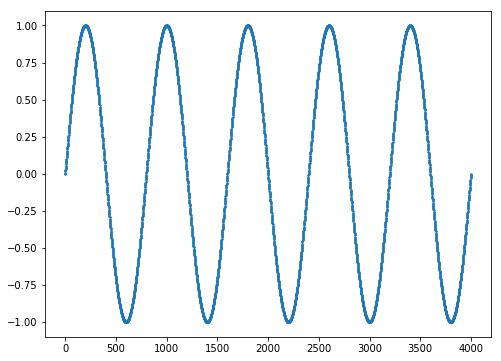

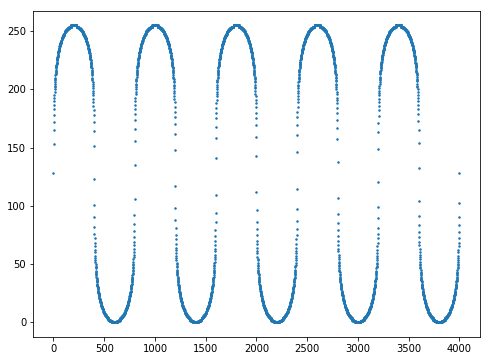

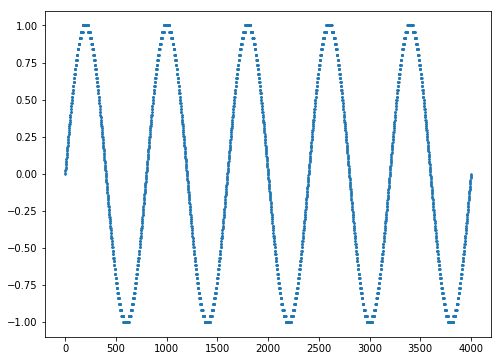

In [11]:
x = next(g)
plt.figure(figsize=[8,6])
plt.plot(Variable(x).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_encoder(x)
plt.figure(figsize=[8,6])
plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_decoder(temp)
plt.figure(figsize=[8,6])
plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

# Load / Save functions

In [8]:
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print("Checkpoint saved: " + filename)

In [9]:
def load_checkpoint(filename):
    net = WaveNet()

    checkpoint = torch.load(filename)
    net.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']
    loss_save = checkpoint['loss_save']
    optimizer = optim.Adam(net.parameters(),lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    print("Loaded checkpoint: " + filename)
    return net, epoch, loss_save, optimizer

# Training

In [24]:
try:
    load_checkpoint("filename")
except:
    print("No checkpoint found - Initializing new training")
    net = WaveNet()
    loss_save = []
    epoch = 0
    optimizer = optim.Adam(net.parameters(), lr = 0.001)

batch_size = 16
max_epoch = 200

for _ in range(max_epoch):
    epoch += 1
    optimizer.zero_grad()
    loss = 0
    
    for ind in range(batch_size):
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        sz = logits.size(0)
        loss = loss + nn.functional.cross_entropy(logits, batch[0][0][-sz:])
        print("Batch " + str(ind) + " done")
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    
    # monitor progress
    if epoch%1 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(x.data.tolist(),'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()
        
        cp = "checkpoint_epoch_" + str(epoch) + "_" + strftime("%Y_%m_%d__%H_%M", localtime()) + '.pth'
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'loss_save' : loss_save,
        }, cp)

No checkpoint found - Initializing new training
Batch 0 done


KeyboardInterrupt: 

# Predicting from sine data

In [ ]:
batch = next(g)
x = mu_encoder(batch).type(torch.LongTensor)
n = 1000
predict_save = []

for _ in range(n):
    temp = Variable(x)
    inputs = temp[0][0][:-1]
    predict = net(inputs)
    _, i = predict.max(dim=1)
    predict_save.append(i.data[-1])
    x = np.roll(x, -1, axis=2)
    x[0][0][-1] = i.data[-1]
    x = torch.from_numpy(x)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.xlim([0, 1000])

# Predict from random data

In [20]:
x = torch.from_numpy(np.random.randint(256, size=(1,1,4000)))
n = 1000
predict_save = []

for _ in range(n):
    temp = Variable(x)
    inputs = temp[0][0][:-1]
    predict = net(inputs)
    _, i = predict.max(dim=1)
    predict_save.append(i.data[-1])
    x = np.roll(x, -1, axis=2)
    x[0][0][-1] = i.data[-1]
    x = torch.from_numpy(x)


( 0  ,.,.) = 
  0.0000  0.0079  0.0157  ...  -0.0157 -0.0079 -0.0000
[torch.FloatTensor of size 1x1x4000]


( 0  ,.,.) = 
  188  136  134  ...   230   26  152
[torch.LongTensor of size 1x1x4000]



In [ ]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.xlim([0, 1000])